#Reyes, Marcus 2015-89006
EE 298 M-MOZQ

November 2020

FMLA02 - Numpy Implementation of an MLP

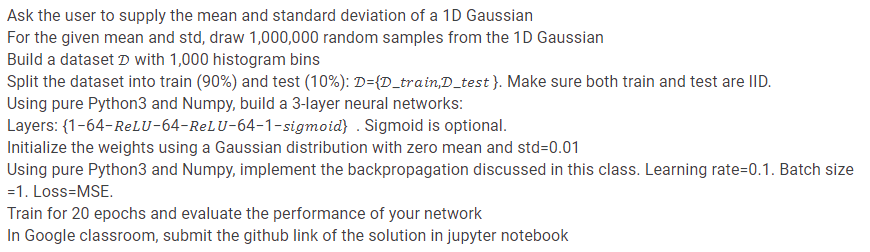

In [11]:
import numpy as np
from math import pi
from matplotlib import pyplot as plt

#Utility Functions

In [12]:
def gaussianpdf(inp, mean, std):
    firstterm = 1/(np.sqrt(2*pi*(std**2)))
    secondterm = np.exp(-((inp-mean)**2)/(2*(std**2)))
    out = firstterm*secondterm
    return out
def sigmoid(x):
    try:
        return 1/(1+np.exp(-x))
    except:
        print("Overflow in sigmoid")
        return np.zeros((1,1))
def to_shuffle(data_prob_gt, data_set):
    perm = np.random.permutation(len(data_prob_gt))
    return data_prob_gt[perm], data_set[perm]

#Dataset Generation

According to the instructions first we must sample 1 million times from a 1-D Gaussian distribution with user inputs to determine the mean and standard deviation.

Previously instructions were to limit the range from [mean-2\*standard deviation, mean + 2\*standard deviation], since this was removed in the updated instructions, `limit_range` is set to `False`.

Since previous instructions on lecture slides where for a 1000 size dataset. I will take 1000 samples from this 1 million samples.

The option to use the pdf as ground truth as opposed to the discretized p(x) from the binning can be enabled by setting `pdf_gt_flag` to `True`



Data mean? (Type 0 for default)0
Data stdev? (Type 1 for default)1


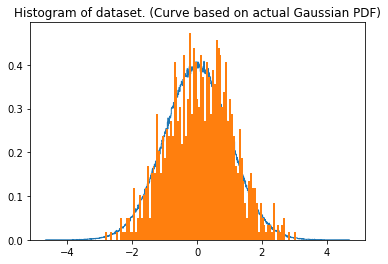

In [13]:
data_mean = float(input("Data mean? (Type 0 for default)"))
data_stdev = float(input("Data stdev? (Type 1 for default)"))

#Flat
limit_range = False
pdf_gt_flag = False

data_gaussian = np.random.normal(data_mean, data_stdev, (1000000))
data_list = []
if limit_range == True:
    while len(data_list) < 1000000:
        temp_data = np.random.normal(data_mean, data_stdev, 1)
        if temp_data > data_mean-2*data_stdev and temp_data < data_mean + 2*data_stdev:
            data_list.append(temp_data)
    data_gaussian = np.array(data_list)

#Reshape into (1000000,1,1) to fit the MLP input requirements
data_gaussian = data_gaussian.reshape(len(data_gaussian),1,1)

#Bin the data
bin_data_for_plot = data_gaussian.copy().reshape(len(data_gaussian),1)
bin_data, bin_edges = np.histogram(bin_data_for_plot,bins = 1000)

#Assign probabilities for each bin
bin_prob = np.zeros(len(bin_data))
for i in range(len(bin_data)):
    bin_prob[i] = bin_data[i]/sum(bin_data)


#Take one thousand samples. Previous specifications had only a data set of 1000.
data_set = np.random.choice(data_gaussian.copy().reshape(len(data_gaussian)), 1000, replace = True)

#Assign ground truth probabilities based on the binning and NOT the pdf
if pdf_gt_flag == False:
    data_prob_gt = np.zeros((data_set.shape))
    for i, item in enumerate(data_set):
        for j, edges in enumerate(bin_edges):
            if item < edges:
                data_prob_gt[i] = bin_prob[j-1]
                break
    #To help the model learn. since the probabilities of 4e-3 are too small
    #This also scales the probabilites to around 0.4 for the mean which is closer to the Gaussian pdf formula
    #Note that the extreme binning causes probabilites of around 4e-3 for the bin containing the mean
    data_prob_gt = data_prob_gt*100
    
#Option to assign ground turth probabilites based on the Gaussian PDF formula
elif pdf_gt_flag == True:
    data_prob_gt = np.zeros((data_set.shape))
    for i, item in enumerate(data_set):
        data_prob_gt[i] = gaussianpdf(data_set[i], data_mean, data_stdev)

data_set = data_set.reshape(1000,1,1)
train_data = data_set[0:int(0.9*len(data_set))]
train_data_prob_gt = data_prob_gt[0:int(0.9*len(data_set))]
test_data = data_set[int(0.9*len(data_set)):]
test_data_prob_gt = data_prob_gt[int(0.9*len(data_set)):]

data_for_plot = data_gaussian.copy().reshape(len(data_gaussian),1)
data_for_plot2 = data_set.copy().reshape(len(data_set),1)
plt.hist(data_for_plot, 1000, density = True, histtype = "step")
plt.hist(data_for_plot2, 100, density = True)
plt.title("Histogram of dataset. (Curve based on actual Gaussian PDF)")
plt.show()


#Network Building

1 - 64 - ReLU - 64 - ReLU - 64 - 1 - sigmoid

The network is hardcoded especially the backpropagation. The weights and biases are initialized using a Gaussian distribution with a mean of 0 and a standard deviation of 0.01

Parameter updates are calculated using backpropgation to numerically compute the values of dL/dW (for weights) and dL/dB (for biases)

Using the convention $$ f_{n+1} = \sigma(z_{n+1}) = \sigma(W_n \cdot f_{n} + B_{n}) $$

Let $W_n$ be the weights of hidden layer n starting at 0

Let $B_n$ be the biases of hidden layer n starting at 0

Let $\sigma$ be the activation function

Let $f_{n}$ be the output of hidden layer n-1 such that $f_0$ is the input data

Let $z_{n}$ be the pre-activation output of hidden layer n-1


Then as a sample, computing for the "updates" for $W_1$ is as follows

$$ \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial z_3}\frac{\partial z_3}{\partial f_2}\frac{\partial f_2}{\partial z_2}\frac{\partial z_2}{\partial W_1} $$

$$ \frac{\partial L}{\partial W_1} = [-2(GT-f_3)]\cdot[(\sigma(z_3))(1-(\sigma(z_3)))]\cdot[W_2]\cdot[ReLU']\cdot [f_1] $$

with each term in square brackets corresponding to one derivative term.

There are some slight manipulations to do this for matrices. Such as going step by step from left to right inverting the order except for the last term (Remember that matrix multiplication is not commutative). But the general formula remains the same.


In [14]:
class MLP():
    def __init__(self):
        self.net_params = []
        self.net_biases = []
        self.act_list = []
        self.net_params_size = [(1,64), 'relu', (64,64), 'relu', (64,1), 'sigmoid']
        self.net_sequence = ['mlp', 'relu', 'mlp', 'relu', 'mlp', 'sigmoid']
        self.overflowcount = 0
        for i in range(len(self.net_params_size)):
            if self.net_params_size[i] == 'relu':
                self.net_params.append('relu')
                self.net_biases.append('relu')
            elif self.net_params_size[i] == 'sigmoid':
                self.net_params.append('sigmoid')
                self.net_biases.append('sigmoid')
            else:
                self.net_params.append(np.random.normal(0, 0.01, self.net_params_size[i]))
                self.net_biases.append(np.random.normal(0, 0.01, self.net_params_size[i][1]))



    def forward(self, inp):
        self.act_list = []
        act = inp #act for activations
        self.act_list.append(act)
        for i in range(len(self.net_params)):
            #Relu layer
            if i == 1 or i == 3:
            #if self.net_params[i] == 'relu':
            #This conditional raises warnings
                act = act.clip(min = 0)
            
            #Sigmoid layer
            elif i == 5:
            #This conditional raises warnings
            #elif self.net_params[i] == 'sigmoid':
                #try except to handle overflows
                try:
                    temp = np.exp(-act)
                    act = 1/(1+temp)
                except:
                    self.overflowcount += 1
                    act = np.zeros((1,1))
            
            #Hidden layers
            else:
                act = np.matmul(act, self.net_params[i])
                act = act + self.net_biases[i]
            self.act_list.append(act)
        output = act
        return output


    def backprop(self, loss, pred, target):
        #key is swapping when doing the chain rule except for the f term
        #Using the convention f_n = activation(z_n) = activation(w_n-1fn-1 + b_n-1)
        #We have x, W_0, W_1, W_2, f_1, f_2, f_3, z_1, z_2, z_3
        #x => input
        #W_i => weights of nth hidden layer starting at 0
        #z_i => preactivation of output of layer i - 1 also eventually input to hidden layer i
        #f_i => activations of hidden layer i-1 used as input to hidden layer i; such that f_0 == x

        #actlist = [input - z1 - f1 - z2 - f2 - z3 - f3]
        #net_params = [W0, relu, W1, relu, W2, sigmoid]

        ##DLDW2 Computation###################################################
        #dldw2 = dldz3*dz3dW2
        dldz3 = -2*(target - pred)*(sigmoid(self.act_list[6]))*(1-sigmoid(self.act_list[6]))
        dz3dW2 = self.act_list[4].copy()

        dldW2 = dldz3*dz3dW2
        dldW2 = dldW2.T

        ##DLDW1 Computation####################################################
        #dldW1 = dz3df2*df2dz2*dz2dW1
        dz3df2 = self.net_params[4].copy() #W2

        df2dz2 = self.act_list[4].copy() #f2 since W2 dep on f2
        df2dz2[df2dz2 <= 0] = 0
        df2dz2[df2dz2 > 0] = 1

        dz2dW1 = self.act_list[2].copy()

        #Go from left to right but swapping terms if it does not contain f
        dldW1 = np.matmul(dz3df2, dldz3)
        dldW1 = df2dz2.T*dldW1
        dldW1 = np.matmul(dldW1, dz2dW1)

        #Remember to transpose
        dldW1 = dldW1.T

        #dldW0 Computation####################################################
        ##Needed terms
        dz2df1 = self.net_params[2].copy() #W1

        df1dz1 = self.act_list[2].copy() #f1
        df1dz1[df1dz1 <= 0] = 0
        df1dz1[df1dz1 > 0] = 1

        dz1dW0 = self.act_list[0].copy() #input

        dldW0 = np.matmul(dz3df2, dldz3)
        dldW0 = df2dz2.T*dldW0
        dldW0 = np.matmul(dz2df1, dldW0)
        dldW0 = df1dz1.T*dldW0
        dldW0 = np.matmul(dldW0, dz1dW0)

        #Remember to transpose
        dldW0 = dldW0.T
        
        ###Bias computation###################################################
        #Same as weights but replace all act_lists with 1
        dz3dB2 = np.ones((1,1))
        dldB2 = np.matmul(dldz3, dz3dB2)
        dldB2 = dldB2.T

        dz2dB1 = np.ones((1,1))
        dldB1 = np.matmul(dz3df2, dldz3)
        dldB1 = df2dz2.T*dldB1
        dldB1 = np.matmul(dldB1, dz2dB1)
        dldB1 = dldB1.T

        dz1dB0 = np.ones((1,1))
        dldB0 = np.matmul(dz3df2, dldz3)
        dldB0 = df2dz2.T*dldB0
        dldB0 = np.matmul(dz2df1,dldB0)
        dldB0 = df1dz1.T*dldB0
        dldB0 = np.matmul(dldB0, dz1dB0)
        dldB0 = dldB0.T

        return dldW2, dldW1, dldW0, dldB2, dldB1, dldB0

    def update_weights_and_biases(self,dldW2, dldW1, dldW0, dldB2, dldB1, dldB0, lr = 0.1,):
        self.net_params[0] = self.net_params[0] - lr*dldW0
        self.net_biases[0] = self.net_biases[0] - lr*dldB0

        self.net_params[2] = self.net_params[2] - lr*dldW1
        self.net_biases[2] = self.net_biases[2] - lr*dldB1

        self.net_params[4] = self.net_params[4] - lr*dldW2
        self.net_biases[4] = self.net_biases[4] - lr*dldB2
        return


    def MSEerror(self, prediction, target):
        loss = (target - prediction)**2
        return loss

#Network Training

First Initialize the Network.

Obtain its untrained predictions on the test data.

Train for `train_epochs` amount of epochs. `train_epochs` is defaulted to 20. Shuffling is performed per epoch. Learning rate is set to `lr = 0.1`


In [15]:
a = MLP()

###Needed for the "try except" for sigmoid
np.seterr(over = 'raise')

#For plotting the initial guesses of the network on the test data
pretraining_guess_list = []
for i in range(len(test_data)):
    out = a.forward(test_data[i])
    target = test_data_prob_gt[i]
    loss = a.MSEerror(out, target)
    pretraining_guess_list.append(out[0][0])


print("Training")
#Training the Network
running_loss_list = []
j = 0
train_epochs = 20
max_epochs = 1
while(j < train_epochs):
    lr = 0.1
    j = j + 1
    running_loss = []
    train_data_prob_gt, train_data = to_shuffle(train_data_prob_gt, train_data)
    for i in range(len(train_data)):
        out = a.forward(train_data[i])
        target = train_data_prob_gt[i]
        loss = a.MSEerror(out, target)
        running_loss.append(loss[0][0])
        dw2,dw1,dw0,db2,db1,db0 = a.backprop(loss, out, target)
        a.update_weights_and_biases(dw2,dw1,dw0,db2,db1,db0, lr = lr)
    running_loss_list.append(sum(running_loss)/len(running_loss))
    if (j)%1 == 0:
        print("Epoch", j,": ave loss", sum(running_loss)/len(running_loss))

print("Noting how many times the try except for overflow was used: ", a.overflowcount)

Training
Epoch 1 : ave loss 0.013263427154105898
Epoch 2 : ave loss 0.010554615392961954
Epoch 3 : ave loss 0.010500913210843402
Epoch 4 : ave loss 0.010542096641056816
Epoch 5 : ave loss 0.010499935155414147
Epoch 6 : ave loss 0.010471249530754486
Epoch 7 : ave loss 0.010533617448439201
Epoch 8 : ave loss 0.010455737464114942
Epoch 9 : ave loss 0.01046947200251932
Epoch 10 : ave loss 0.010280054059874904
Epoch 11 : ave loss 0.009601436522713964
Epoch 12 : ave loss 0.006277045969695108
Epoch 13 : ave loss 0.0011118684643520599
Epoch 14 : ave loss 0.0002054569899663471
Epoch 15 : ave loss 0.00016055085706160867
Epoch 16 : ave loss 0.00014955976194191745
Epoch 17 : ave loss 0.00013146470023123235
Epoch 18 : ave loss 0.00010704327588118575
Epoch 19 : ave loss 8.093867948301233e-05
Epoch 20 : ave loss 6.449264460002966e-05
Noting how many times the try except for overflow was used:  0


#Results
First, the predictions of the trained network on the test data are obtained

Then the following are plotted: the ground truth pdf of the Test Data set, the pdf of the test data as predicted by the untrained MLP, and the pdf of the test data as predicted by the trained MLP.

The graphs indicate that the 3-layer MLP is able to learn the pdf of the dataset.

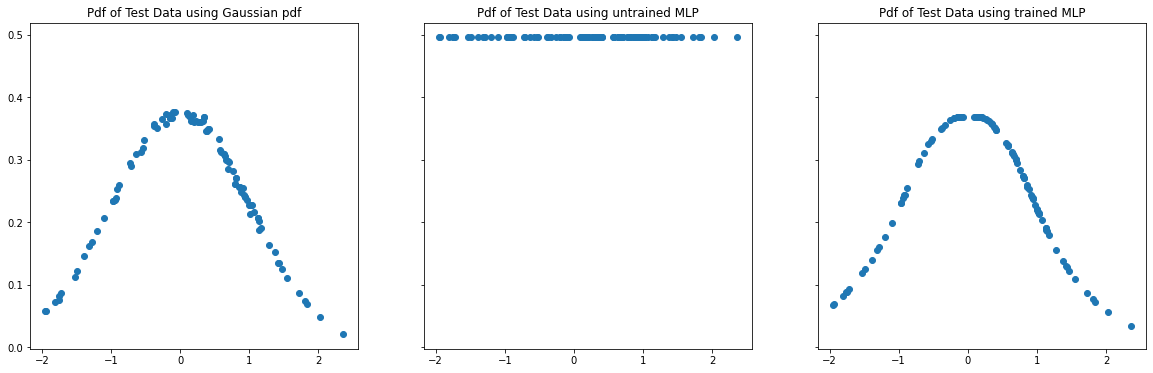

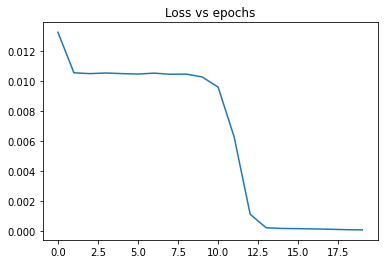

900


In [16]:
#Obtain the predictions of the trained network on the test data
output_list = []
for i in range(len(test_data)):
    out = a.forward(test_data[i])
    #target = gaussianpdf(train_data[i], data_mean, data_stdev)
    target = test_data_prob_gt[i]
    loss = a.MSEerror(out, target)
    output_list.append(out[0][0])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,6), sharey = True)


actual_gaussian_pdf_list = []
for i in range(len(test_data)):
    #actual_gaussian_pdf_list.append(gaussianpdf(test_data[i], data_mean, data_stdev))
    actual_gaussian_pdf_list.append(test_data_prob_gt[i])

axes[0].scatter(test_data, actual_gaussian_pdf_list)
axes[0].title.set_text('Pdf of Test Data using Gaussian pdf')
axes[1].scatter(test_data, pretraining_guess_list)
axes[1].title.set_text('Pdf of Test Data using untrained MLP')
axes[2].scatter(test_data, output_list)
axes[2].title.set_text('Pdf of Test Data using trained MLP')

plt.figure()
plt.plot(running_loss_list)
output_list = np.array(output_list)
plt.title("Loss vs epochs")
plt.show()
print(len(train_data))